In [8]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from skimage import io
import time

import warnings
warnings.filterwarnings("ignore")


In [9]:
class Veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # Veri kümesi sınıfının yapıcı metodunu tanımlama
        # csv_file: Etiket bilgilerini içeren CSV dosyasının yolu
        # root_dir: Görüntülerin bulunduğu kök dizin (root directory)
        # transform: Görüntülere uygulanacak dönüşümler
        self.annotations = pd.read_csv(csv_file)  # CSV dosyasını oku ve etiket bilgilerini içeren bir veri çerçevesi oluştur
        self.root_dir = root_dir  # Görüntülerin bulunduğu kök dizini
        self.transform = transform  # Görüntülere uygulanacak dönüşümler

    def __len__(self):
        # Veri kümesindeki örnek sayısını döndürme
        return len(self.annotations)

    def __getitem__(self, index):
        # Belirli bir indeksteki örneği getirme

        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        # Görüntünün dosya yolunu oluşturma
        image = io.imread(img_path)  # Görüntüyü okuma (Değiştirilmiş satır: io.read_image'den io.imread'e)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        # Etiketi tensor'a çevirme

        if self.transform:
            # Eğer dönüşüm varsa, görüntüye dönüşümü uygulama
            image = self.transform(image)

        return (image, y_label)
        # İlgili görüntü ve etiketi içeren bir tuple döndürme


#### Veri kümesi oluşturma

In [10]:
dataset = Veri(
    csv_file="/Users/abdulbarisoylemez/Documents/Visual Code/Yapay Zeka ve Bilgisayarlı Görü Mühendisi/İsaretDiliCNNtespiti/fotograf_etiketler.csv",
    root_dir="/Users/abdulbarisoylemez/Documents/Visual Code/Bitirme Projesi/kod/data/isaretData",
    transform=transforms.Compose([ 
        transforms.ToTensor(),  # Görüntüyü PyTorch tensor'ına dönüştürme
        transforms.Resize(size=(64, 64)),  # Görüntü boyutunu (64x64) piksele yeniden boyutlandırma
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Görüntüyü normalleştirme
    ])
)

####  eğitim ve test alt kümelerine bölelim

In [11]:
total_length = len(dataset)  # Veri kümesinin toplam örnek sayısı

train_length = 1500  # Eğitim verisi sayısı
test_length = total_length - train_length  # Test verisi sayısı

# Veri kümesini rastgele iki alt kümeye ayırma
train_set, test_set = torch.utils.data.random_split(dataset, [train_length, test_length])

# DataLoader'ları oluşturmak:
# DataLoader, veri kümesini mini-batch'ler halinde yüklemek için kullanılır.

# Eğitim veri yükleyici oluşturma
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)

# Test veri yükleyici oluşturma
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)


#### veri kümesinden rastgele bir örnek alarak bunu görseleştirelim

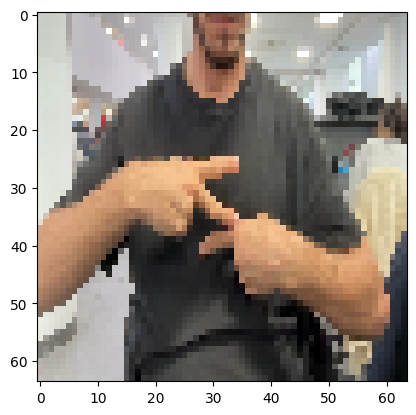

Z    
torch.Size([1, 3, 64, 64])


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Batch boyutu ve etiket sınıfları
batch_size = 1
classes = ["A", "B", "Bosluk", "C", "D", "DOT", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "R", "S", "SPACE", "T", "U", "V", "Y", "Z"]

# imshow fonksiyonu: Görüntüyü ekrana çizdirme fonksiyonu
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Veri yükleyicisinden bir iteratör al
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Görüntüleri çizdir
imshow(torchvision.utils.make_grid(images))

# Etiketleri yazdır
print(' '.join("%-5s" % classes[labels[j]] for j in range(batch_size)))
print(images.size())


#### CNN katmanımızı oluşturalım 

In [13]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        # __init__ fonksiyonu: Modelin katmanlarını tanımladığımız yer

        super(Net, self).__init__()

        # Convolutional (Conv) katmanlar:
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5))

        # Max pooling katmanı:
        self.max = nn.MaxPool2d(kernel_size=(2, 2))

        # Activation fonksiyonu (Exponential Linear Unit - ELU):
        self.func = nn.ELU()

        # Tam bağlı (Fully Connected) katmanlar:
        self.fc1 = nn.Linear(in_features=64, out_features=124)
        self.fc2 = nn.Linear(in_features=124, out_features=124)
        self.fc3 = nn.Linear(in_features=124, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=25)

    def forward(self, x):
        # forward fonksiyonu: Modelin veriyi nasıl işleyeceğini tanımladığımız yer

        # Conv1 katmanı:
        x = self.conv1(x)
        x = self.func(x)
        x = self.max(x)

        # Conv2 katmanı:
        x = self.conv2(x)
        x = self.func(x)
        x = self.max(x)

        # Conv3 katmanı:
        x = self.conv3(x)
        x = self.func(x)
        x = self.max(x)

        # Conv4 katmanı:
        x = self.conv4(x)
        x = self.func(x)

        # Flatten (Düzleştirme):
        x = x.view(x.size(0), -1)

        # FC1 katmanı:
        x = self.fc1(x)
        x = self.func(x)

        # FC2 katmanı:
        x = self.fc2(x)
        x = self.func(x)

        # FC3 katmanı:
        x = self.fc3(x)
        x = self.func(x)

        # FC4 katmanı:
        x = self.fc4(x)

        return x


### Tensorboard ile model eğitimi süresince inşa etiğimiz yapay sinir ağlarını görseleştirebilir ve aynı zamanda interaktif grafikler de çizmemize yarar

In [16]:
import time
from itertools import product
import torch
import torch.optim as optim
import torchvision
from torch.utils.tensorboard import SummaryWriter

# Zamanı başlat
start_time = time.time()

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# Denenecek parametre setleri
parametre = dict(lr=[0.1, 0.01, 0.001], batch_size=[1, 2])
parametre_values = [v for v in parametre.values()]

# Parametre setleri üzerinde döngü
for lr, batch_size in product(*parametre_values):

    # Modeli oluştur
    model = Net()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    error = torch.nn.CrossEntropyLoss()

    # TensorBoard için bir yazıcı oluştur
    tensorboard = SummaryWriter(comment=f"batch_size={batch_size}lr")

    # TensorBoard'a örnek görüntüleri ve model grafiğini ekle
    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)
    tensorboard.add_image("images", grid)
    tensorboard.add_graph(model, images)

    # Belirli sayıda epoch için eğitim gerçekleştir
    for epoch in range(5):
        total_loss = 0
        total_correct = 0

        # Eğitim verileri üzerinde döngü
        for i, (images, labels) in enumerate(train_loader):
            preds = model(images)
            loss = error(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Toplam kayıp ve doğru tahmin sayısını güncelle
            total_loss += loss.item() * batch_size
            total_correct += get_num_correct(preds, labels)

        # TensorBoard'a metrikleri ekle
        tensorboard.add_scalar("Loss", total_loss, epoch)
        tensorboard.add_scalar("Accuracy", total_correct / len(train_set), epoch)
        tensorboard.add_scalar("Number Correct", total_correct, epoch)

        # Hyperparameter'ları ve metrikleri TensorBoard'a ekle
        tensorboard.add_hparams({"Ir": lr, "batch_size": batch_size},
                                {"Accuracy": total_correct / len(train_set),
                                 "loss": total_loss})

        # Model parametrelerinin histogramlarını TensorBoard'a ekle
        for name, param in model.named_parameters():
            tensorboard.add_histogram(name, param, epoch)
            tensorboard.add_histogram(f"{name}.grad", param.grad, epoch)

        # Eğitim sonuçlarını ekrana yazdır
        print(f"Epoch {epoch}, Total Correct: {total_correct}, Loss: {total_loss}")

    # TensorBoard'ı kapat
    tensorboard.close()

# Zamanı bitir ve süreyi yazdır
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Toplam süre: {elapsed_time} saniye")


Epoch 0, Total Correct: 59, Loss: 1862316.065297426
Epoch 1, Total Correct: 71, Loss: 23401.07296476879
Epoch 2, Total Correct: 49, Loss: 24909.67605865805
Epoch 3, Total Correct: 53, Loss: 39778.284644441745
Epoch 4, Total Correct: 52, Loss: 24591.802977132727
Epoch 0, Total Correct: 60, Loss: 37001563.721271545
Epoch 1, Total Correct: 64, Loss: 39878.12775701727
Epoch 2, Total Correct: 56, Loss: 42510.076608050615
Epoch 3, Total Correct: 56, Loss: 44930.34388879314
Epoch 4, Total Correct: 50, Loss: 42824.76464416995
Epoch 0, Total Correct: 47, Loss: 6621.960528075695
Epoch 1, Total Correct: 61, Loss: 6746.3187066316605
Epoch 2, Total Correct: 55, Loss: 6827.707042962313
Epoch 3, Total Correct: 71, Loss: 6824.995715081692
Epoch 4, Total Correct: 55, Loss: 6739.722099095583
Epoch 0, Total Correct: 51, Loss: 15639.826634973288
Epoch 1, Total Correct: 58, Loss: 13277.085108578205
Epoch 2, Total Correct: 69, Loss: 13512.349755048752
Epoch 3, Total Correct: 60, Loss: 13390.855207383633
Epo

#### tensorboard --logdir=runs 
cmd de projenin bulunduğu klasöre gel ve bunu çalıştır ve sana bir host verecek ve bu hos değikenini cromdan açtığın zaman sizleri bir TensorBoard sayfasına yönlendirecektir 